<a href="https://colab.research.google.com/github/neerajgoyal12/electoral_bonds/blob/main/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as pd
from pathlib import Path
import requests
import matplotlib.pyplot as plt

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/neerajgoyal12/electoral_bonds/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

if Path("ec_data.csv").is_file():
  print("ec_data.csv already exists, skipping download")
else:
  print("Downloading ec_data.csv")
  request = requests.get("https://raw.githubusercontent.com/neerajgoyal12/electoral_bonds/main/data/ec_data.csv")
  with open("ec_data.csv", "wb") as f:
    f.write(request.content)


In [2]:
df = pd.read_csv('ec_data.csv')

In [3]:
df.head(5)

,Date of Purchase,Purchaser Name,Denomination,Unnamed: 3
0,12/Apr/2019,A B C INDIA LIMITED,100000,NaN
1,12/Apr/2019,A B C INDIA LIMITED,100000,NaN
2,12/Apr/2019,A B C INDIA LIMITED,1000000,NaN
3,12/Apr/2019,A B C INDIA LIMITED,1000000,NaN
4,12/Apr/2019,A B C INDIA LIMITED,100000,NaN


In [4]:
df.tail(5)

,Date of Purchase,Purchaser Name,Denomination,Unnamed: 3
18866,11/Jan/2024,WESTWELL GASES PRIVATE LIMITED,10000000,NaN
18867,11/Jan/2024,WESTWELL GASES PRIVATE LIMITED,10000000,NaN
18868,11/Jan/2024,WESTWELL GASES PRIVATE LIMITED,10000000,NaN
18869,11/Jan/2024,WESTWELL GASES PRIVATE LIMITED,10000000,NaN
18870,11/Jan/2024,WESTWELL GASES PRIVATE LIMITED,10000000,NaN


In [5]:
#dropping NaN column
df = df.dropna(axis = 1, how = 'all')
df

,Date of Purchase,Purchaser Name,Denomination
0,12/Apr/2019,A B C INDIA LIMITED,100000
1,12/Apr/2019,A B C INDIA LIMITED,100000
2,12/Apr/2019,A B C INDIA LIMITED,1000000
3,12/Apr/2019,A B C INDIA LIMITED,1000000
4,12/Apr/2019,A B C INDIA LIMITED,100000
...,...,...,...
18866,11/Jan/2024,WESTWELL GASES PRIVATE LIMITED,10000000
18867,11/Jan/2024,WESTWELL GASES PRIVATE LIMITED,10000000
18868,11/Jan/2024,WESTWELL GASES PRIVATE LIMITED,10000000
18869,11/Jan/2024,WESTWELL GASES PRIVATE LIMITED,10000000


In [6]:
# For future easy ness
dstr = 'Date of Purchase'
pnstr = 'Purchaser Name'
denostr = 'Denomination'

In [7]:
df.infer_objects()
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18871 entries, 0 to 18870
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   Date of Purchase  18871 non-null  object
 1   Purchaser Name    18871 non-null  object
 2   Denomination      18871 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 442.4+ KB


In [8]:
# Converting dtypes for later convenience
df[dstr] = pd.to_datetime(df[dstr])
df[pnstr] = df[pnstr].astype(str)

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18871 entries, 0 to 18870
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date of Purchase  18871 non-null  datetime64[ns]
 1   Purchaser Name    18871 non-null  object        
 2   Denomination      18871 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(1)
memory usage: 442.4+ KB


In [9]:
# prompt: in df clean pnstr

import re

def clean_string(string):
  # Remove leading and trailing whitespace
  string = string.strip()
  # Convert to lowercase
  string = string.lower()
  # Remove special characters
  string = re.sub(r'[^a-zA-Z0-9\s]', '', string)
  # Remove multiple spaces
  string = re.sub(r'\s+', ' ', string)
  return string

df[pnstr] = df[pnstr].apply(clean_string)


In [10]:
# prompt: in df pnstr replace 'megha engineering infrastructures limited'  with ' 'megha engineering and infrastructures limited'

df[pnstr] = df[pnstr].apply(lambda x: x.replace('megha engineering infrastructures limited', 'megha engineering and infrastructures limited'))
df[pnstr] = df[pnstr].apply(lambda x: x.replace('ltd', 'limited'))
df[pnstr] = df[pnstr].apply(lambda x: x.replace('pvt', 'private'))
df[pnstr] = df[pnstr].apply(lambda x: x.replace('l td', 'limited'))
df[pnstr] = df[pnstr].apply(lambda x: x.replace('l mited', 'limited'))


In [11]:
# prompt: in df pnstr replace '.' with ' '
df[pnstr] = df[pnstr].apply(lambda x: x.replace('.', ' '))

In [12]:
grouped_df = df.groupby(pnstr, sort=False).sum(numeric_only=True).copy()
grouped_df.reset_index(inplace=True)
grouped_df.sort_values(by=denostr, ascending=False, inplace=True)

In [13]:
!pip install jellyfish
from jellyfish import jaro_similarity

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.2/1.2 MB 11.0 MB/s eta 0:00:00


In [14]:
def combine_similar_names(df, threshold=0.9):
  """
  Combines rows in a DataFrame where the 'Purchaser Name' column values are similar by a specified threshold.

  Args:
      df: The DataFrame to process.
      threshold: The similarity threshold (0 to 1) for combining names.

  Returns:
      A new DataFrame with combined rows.
  """

  combined_df = df.copy()
  for i in range(len(df)):
    for j in range(i + 1, len(df)):
      name1 = df.loc[i, 'Purchaser Name']
      name2 = df.loc[j, 'Purchaser Name']
      names1 = name1.split()
      names2 = name2.split()
      first_similarity = jaro_similarity(names1[0], names2[0])
      # print(f"i: {names1[0]} j: {j} {names2[0]} | {first_similarity}")
      if first_similarity < 0.97:
        continue
      else:
        similarity = jaro_similarity(name1, name2)
        if similarity >= threshold:
          combined_df.loc[i, 'Denomination'] += df.loc[j, 'Denomination']
          # print(f"i: {i} j: {j} {name1} | {name2} | {similarity}")
          combined_df.drop(index=j, inplace=True)
          combined_df.reset_index(inplace=True, drop=True)
        else:
          # print(f"i: {i} j: {j} {name1} | {name2} | {similarity}")
          pass
  return combined_df


In [15]:
# droppinf donners below 1 cr
above_1_cr_grouped_df = grouped_df[grouped_df[denostr] > 10000000].copy()
above_1_cr_grouped_df.tail()

,Purchaser Name,Denomination
1146,harijan hiribai,10768000
1143,bhachiben khamubhai manvar,10768000
1154,rathod lakhiben,10768000
470,ranisati mercantiles private limited,10500000
65,raipur botling company,10001000


In [16]:
print(f"Highest Donation : {above_1_cr_grouped_df[denostr].max()}")
print(f"Lowest Donation : {above_1_cr_grouped_df[denostr].min()}")
above_1_cr_grouped_df[denostr] = above_1_cr_grouped_df[denostr] / 10000000

Highest Donation : 12080000000
Lowest Donation : 10001000


In [17]:
above_1_cr_grouped_reseted_df = above_1_cr_grouped_df.reset_index(drop=True, inplace=False).copy()
print(f"Above 1 cr total: {len(above_1_cr_grouped_reseted_df)}")
above_1_cr_grouped_combined_df = combine_similar_names(above_1_cr_grouped_reseted_df, threshold=0.90)
print(f"After combining similar names: {len(above_1_cr_grouped_combined_df)}")

Above 1 cr total: 646
After combining similar names: 624


In [18]:
# prompt: convert denomination to indian rupee in crore
above_1_cr_grouped_df[denostr] = above_1_cr_grouped_df[denostr] / 10000000
print(f"Total unique donors above 1cr: {len(above_1_cr_grouped_combined_df)}")

Total unique donors above 1cr: 624


In [19]:
top_30_donors = above_1_cr_grouped_combined_df.head(30).copy()
top_30_donors.head()

,Purchaser Name,Denomination
0,future gaming and hotel services pr,1368.00
1,megha engineering and infrastructures li mited,966.00
2,qwiksupplychainprivatelimited,410.00
3,vedanta limited,400.65
4,haldia energy limited,377.00


In [20]:
top_30_donors_reseted = top_30_donors.reset_index(drop=True, inplace=False).copy()
top_30_donors_reseted.head()

,Purchaser Name,Denomination
0,future gaming and hotel services pr,1368.00
1,megha engineering and infrastructures li mited,966.00
2,qwiksupplychainprivatelimited,410.00
3,vedanta limited,400.65
4,haldia energy limited,377.00


In [21]:
print(f"Before combining : {len(top_30_donors_reseted)}")
top_30_donors_combined = combine_similar_names(top_30_donors_reseted, threshold=0.90)
print(f"After combining : {len(top_30_donors_combined)}")

Before combining : 30
After combining : 29


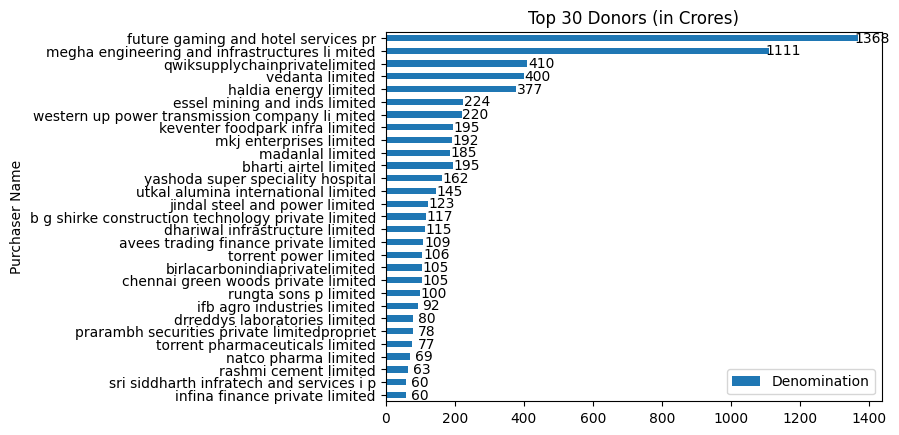

<Figure size 1000x1500 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [22]:
ax = top_30_donors_combined.plot.barh(x=pnstr, y=denostr)

# Add labels for the denominations on the right side of the bars
for i, bar in enumerate(ax.patches):
    ax.text(bar.get_width() + 40, bar.get_y() + bar.get_height() / 2,
            str(int(bar.get_width())), ha='center', va='center')

# Invert the y-axis to show the highest values at the top
plt.gca().invert_yaxis()

# Add a title and show the plot
plt.title("Top 30 Donors (in Crores)")

import os

# Create the directory if it doesn't exist
if not os.path.exists('data'):
  os.makedirs('data')

# Save the figure
plt.figure(figsize=(10,15))
plt.show()
plt.savefig('data/top_30_donors_in_crore.png')

In [23]:
print(f"Length of all 1 cr grouped data: {len(above_1_cr_grouped_reseted_df)}")
all_clean_data = combine_similar_names(above_1_cr_grouped_reseted_df, threshold=0.90)
n = 5
for i in range(5):
  all_clean_data = combine_similar_names(all_clean_data, threshold=0.90)

print(f"Length of all grouped data after {n} pass of removing duplicates: {len(all_clean_data)}")

all_clean_data.head()

Length of all 1 cr grouped data: 646
Length of all grouped data after 5 pass of removing duplicates: 552


,Purchaser Name,Denomination
0,future gaming and hotel services pr,1368.00
1,megha engineering and infrastructures li mited,1111.00
2,qwiksupplychainprivatelimited,410.00
3,vedanta limited,400.65
4,haldia energy limited,377.00


In [24]:
def plot_figure(df_sent, x: str, y: str, step):
  ax = df_sent.plot.barh(x=x, y=y)

  # Add labels for the denominations on the right side of the bars
  for i, bar in enumerate(ax.patches):
      ax.text(bar.get_width(), bar.get_y() + bar.get_height() / 2,
              str(int(bar.get_width())), ha='center', va='center')

  # Invert the y-axis to show the highest values at the top
  plt.gca().invert_yaxis()

  # Add a title and show the plot
  plt.title(f"{step} 30 Donors (in Crores)")

  import os

  # Create the directory if it doesn't exist
  if not os.path.exists('data'):
    os.makedirs('data')

  # Save the figure
  plt.figure(figsize=(10,15))
  plt.show()
  plt.savefig(f"data/{step}_30_donors_in_crore.png")

In [36]:
def my_filter(row, matching: str):
    similarity = jaro_similarity(row[pnstr], matching)
    if similarity > 0.92:
        return True

    return False

def find_first_last_date(name: str, df: pd.DataFrame):
  for i in range(len(df)):
    if len(df.index) > 0:
      # filtered_df = df[df.apply(my_filter(matching=name), axis=1)]
      filtered_df = df[df.apply(lambda x: jaro_similarity(x[pnstr], name) > 0.97, axis=1)]
      min_date = filtered_df[dstr].min()
      max_date = filtered_df[dstr].max()
      return (min_date, max_date)



In [38]:
# prompt: all_clean_data use plot_figure to generate plots for every 30 rows
all_clean_data.sort_values(by=denostr, ascending=False, inplace=True)
for i in range(len(all_clean_data)):
  matching = all_clean_data[pnstr][i]
  min_date, max_date = find_first_last_date(matching, df)
  all_clean_data.loc[i, 'first_donation_date'] = min_date
  all_clean_data.loc[i, 'last_donation_date'] = max_date

In [39]:
all_clean_data.to_csv('1-crore-donar-electoral-bonds.csv')